# Testing tunability of models

In [24]:
# Packages
import copy

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet
from timeit import default_timer as timer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Real, Integer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [25]:
import os
os.getcwd()
np.random.seed(42) 

In [26]:
# diabetes = pd.DataFrame(pd.read_csv("C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/diabetes.csv"))
diabetes = pd.DataFrame(pd.read_csv("../data/diabetes.csv"))
students = pd.DataFrame(pd.read_csv('../data/students.csv'))
# students = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/students.csv'))
students = students.loc[students.Target!='Enrolled']
# telco = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/telco.csv'))
telco = pd.DataFrame(pd.read_csv('../data/telco.csv'))
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'],errors='coerce')
telco = telco.iloc[:,1:] # id column
# pistachio = pd.DataFrame(pd.read_csv('C:/Users/jancw/Desktop/Studia/Sem5/AutoML/Project_1/Datasets/pistachio.csv'))
pistachio = pd.DataFrame(pd.read_csv('../data/pistachio.csv'))
datasets = {'diabetes': diabetes,'students': students,'telco': telco,'pistachio': pistachio}

# Wybór danych i rekonesans

In [27]:
# datasets sizes
for key in datasets:
    print(f'{key} len: {len(datasets.get(key))}')

diabetes len: 100000
students len: 3630
telco len: 7043
pistachio len: 2148


In [28]:
# we need about 1500 rows from each set
random_seed = 24
datasets_wanted_size = {}
for key in datasets:
    dataset_size = len(datasets.get(key))
    X = datasets.get(key)
    y = datasets.get(key).iloc[:,-1]
    rest,data_wanted_size = train_test_split(X,test_size=1500/dataset_size,stratify=y,random_state=random_seed)
    datasets_wanted_size[key] = data_wanted_size

In [29]:
# typy kolumn
for key in datasets_wanted_size:
    print(key + ':')
    print(f'{datasets_wanted_size.get(key).dtypes.value_counts()}\n')

diabetes:
int64      4
float64    3
object     2
Name: count, dtype: int64

students:
int64      29
float64     5
object      1
Name: count, dtype: int64

telco:
object     16
int64       2
float64     2
Name: count, dtype: int64

pistachio:
float64    26
int64       2
object      1
Name: count, dtype: int64



In [30]:
# rozkład y
for key in datasets_wanted_size:
    print(key+':')
    print(f'{datasets_wanted_size.get(key).iloc[:,-1].value_counts()}\n')

# zmieniamy dla każdego zbioru ,y na wartości {0,1}
label_encoder = LabelEncoder()
for key in datasets_wanted_size:
    datasets_wanted_size[key].iloc[:,-1] = label_encoder.fit_transform(datasets_wanted_size[key].iloc[:,-1])
    datasets_wanted_size[key] = datasets_wanted_size[key].astype({datasets_wanted_size.get(key).columns[-1]: 'int64'})

diabetes:
diabetes
0    1373
1     127
Name: count, dtype: int64

students:
Target
Graduate    913
Dropout     587
Name: count, dtype: int64

telco:
Churn
No     1102
Yes     398
Name: count, dtype: int64

pistachio:
Class
Kirmizi_Pistachio    860
Siirt_Pistachio      640
Name: count, dtype: int64



Sprawdzanie wartości zmiennyck o typach 'object'

In [31]:
dataset = datasets_wanted_size.get('diabetes')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

dataset.head(3)

# nulls :
    # czy w gender: 'Other'==null
    # czy w smoking_history 'No info'==null

# object column encoding :
    # gender - 
    # smoking_history - 



gender: ['Male' 'Female']
smoking_history: ['former' 'never' 'ever' 'No Info' 'not current' 'current']


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
60094,Male,62.0,1,1,former,27.32,4.8,155,0
90264,Male,61.0,0,0,never,58.05,5.7,155,1
53832,Female,73.0,0,0,never,27.32,6.5,200,0


In [32]:
dataset = datasets_wanted_size.get('students')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

# kolumny są numeryczne

dataset.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
4310,1,15,1,6,1,14,1,23,27,10,...,1,6,12,6,13.625,0,12.4,0.5,1.79,1
4318,1,1,1,2,1,1,14,1,1,10,...,4,11,12,11,15.000,0,8.9,1.4,3.51,1
209,1,12,1,11,1,12,1,3,14,3,...,0,6,6,5,12.800,0,16.2,0.3,-0.92,0


In [33]:
dataset = datasets_wanted_size.get('telco')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')
    
dataset.head(3)

# object column encoding :
    # wszytkie kolumny wartościach binarnych - label encoding
    # Contract - 
    # TotalCharges - zmiana typu na float, (są wartości ' ' ,które mogą być traktowane jako null)
    # pozostałe - one-hot encoding

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['Yes' 'No' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['Yes' 'No' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['Yes' 'No' 'No internet service']
Contract: ['Two year' 'Month-to-month' 'One year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Credit card (automatic)'
 'Bank transfer (automatic)']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4726,Female,0,Yes,No,72,No,No phone service,DSL,Yes,Yes,Yes,No,No,Yes,Two year,Yes,Electronic check,49.20,3580.95,0
5892,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,51.65,524.50,0
274,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.60,70.60,1


In [34]:
dataset = datasets_wanted_size.get('pistachio')
object_columns = dataset.select_dtypes(include='object')
object_columns_unique_values = {column: dataset[column].unique() for column in object_columns}

for key in object_columns_unique_values:
    print(f'{key}: {object_columns_unique_values.get(key)}')

# kolumny są numeryczne

dataset.head(3)

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
1682,80139,1075.2321,418.1198,244.6082,0.8110,319.4310,0.9928,80719,0.7494,1.7093,...,14.5330,15.2768,14.2298,-0.7579,-0.6986,-0.3487,3.4817,3.2926,2.6470,1
89,85969,2345.6279,421.6958,291.1149,0.7235,330.8461,0.8702,98789,0.7033,1.4486,...,18.2206,18.1049,16.7189,-0.9762,-0.9983,-0.7881,3.1975,3.3114,3.3104,0
2021,95334,1251.7111,488.1582,249.2888,0.8598,348.4007,0.9858,96705,0.7721,1.9582,...,23.4085,24.2855,22.0737,-0.6492,-0.4470,-0.4217,2.6227,2.3029,2.2124,1


# Preprocessing

- jeżeli kolumna ma 2 wartości to label encoding, wpp one-hot encoding ,(może coś innego pomyśleć) - wzialem dummy onehotencoder do pipeline
- 

In [35]:
# notatnik
# diabetes.nunique()==2

# pip_num = Pipeline(steps=[('impute',SimpleImputer()),
#                           ('scale',MinMaxScaler())])
# pip_cat = Pipeline(steps=[
#     ('ohe',OneHotEncoder()),
#     ('impute',SimpleImputer())])

# col_trans = ColumnTransformer([
#     ("numeric",pip_num,make_column_selector(dtype_include= np.number)),
#     ("cat",pip_cat,make_column_selector(dtype_include= np.object_))
# ])

# model_pipeline = Pipeline([("trans",col_trans),("model",RandomForestClassifier())])
# model_pipeline.fit(datasets_X_test.get('telco'),np.array(datasets_y_test.get('telco')))

# Modele

In [36]:
# 1 - DecisionTreeClassifier

# class sklearn.tree.DecisionTreeClassifier(*, 
#                                         criterion='gini',
#                                         splitter='best',
#                                         max_depth=[],
#                                         min_samples_split=2, 
#                                         min_samples_leaf=1, 
#                                         min_weight_fraction_leaf=0.0, 
#                                         max_features=None, 
#                                         random_state=None, 
#                                         max_leaf_nodes=None, 
#                                         min_impurity_decrease=0.0, 
#                                         class_weight=None, 
#                                         ccp_alpha=0.0, 
#                                         monotonic_cst=None)


In [37]:
# 2 - LogisticRegression

# class sklearn.linear_model.LogisticRegression(penalty='l2', 
#                                               *, 
#                                               dual=False, 
#                                               tol=0.0001, 
#                                               C=1.0, 
#                                               fit_intercept=True, 
#                                               intercept_scaling=1, 
#                                               class_weight=None, 
#                                               random_state=None, 
#                                               solver='lbfgs', 
#                                               max_iter=100, 
#                                               multi_class='deprecated', 
#                                               verbose=0, 
#                                               warm_start=False, 
#                                               n_jobs=None, 
#                                               l1_ratio=None)

In [38]:
# 3 - GradientBoostingClassifier

# class sklearn.ensemble.GradientBoostingClassifier(*, 
#                                                   loss='log_loss', 
#                                                   learning_rate=0.1, 
#                                                   n_estimators=100, 
#                                                   subsample=1.0, 
#                                                   criterion='friedman_mse', 
#                                                   min_samples_split=2, 
#                                                   min_samples_leaf=1, 
#                                                   min_weight_fraction_leaf=0.0, 
#                                                   max_depth=3, 
#                                                   min_impurity_decrease=0.0, 
#                                                   init=None, random_state=None, 
#                                                   max_features=None, 
#                                                   verbose=0, 
#                                                   max_leaf_nodes=None, 
#                                                   warm_start=False, 
#                                                   validation_fraction=0.1, 
#                                                   n_iter_no_change=None, 
#                                                   tol=0.0001, 
#                                                   ccp_alpha=0.0)

In [39]:
# Import the required classifiers from scikit-learn

# Create objects of the classifiers
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
ada_boost = AdaBoostClassifier()
bagging_classifier = BaggingClassifier()
k_neighbors = KNeighborsClassifier()
support_vector_machine = SVC()

# Display the classifier objects
classifiers = {
    "Logistic Regression": logistic_regression,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting,
    "AdaBoost": ada_boost,
    "Bagging Classifier": bagging_classifier,
    "K-Neighbors": k_neighbors,
    "Support Vector Machine": support_vector_machine
}

In [40]:
random_seed = 24
datasets_X_train = {}
datasets_X_test = {}
datasets_y_train = {}
datasets_y_test = {}
for key in datasets_wanted_size:
    dataset_size = len(datasets_wanted_size.get(key))
    X = datasets_wanted_size.get(key).iloc[:,:-1]
    y = datasets_wanted_size.get(key).iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=random_seed)
    datasets_X_train[key] = X_train
    datasets_X_test[key] = X_test
    datasets_y_train[key] = y_train
    datasets_y_test[key] = y_test

In [41]:

tabela_wyników = {}

pip_num = Pipeline(steps=[('impute',SimpleImputer()),
                          ('scale',MinMaxScaler())])
pip_cat = Pipeline(steps=[
    ('ohe',OneHotEncoder(drop='first')),
    ('impute',SimpleImputer())])
col_trans = ColumnTransformer([
    ("numeric",pip_num,make_column_selector(dtype_include= np.number)),
    ("cat",pip_cat,make_column_selector(dtype_include= np.object_))
])


example_pipeline = Pipeline([("trans",col_trans),("model",RandomForestClassifier())])
example_pipeline.fit(datasets_X_test.get('telco'),np.array(datasets_y_test.get('telco')))



Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000279130C3140>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('impute',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000279130C2420>)])),
                ('model', RandomForestClassifier())])

In [42]:
set_key = 'students'

for key in classifiers:
    start = timer()
    model_pipeline = Pipeline([("trans",col_trans),("model",classifiers[key])])
    model_pipeline.fit(datasets_X_train.get(set_key),datasets_y_train.get(set_key))    
    end = timer()
    y_hat = model_pipeline.predict(datasets_X_test.get(set_key))
    tabela_wyników[key] = [accuracy_score(y_hat,datasets_y_test.get(set_key)),end-start] #== [accuracy, time]


# pistachio
# {'Logistic Regression': [0.8766666666666667, 0.014618600020185113],
#  'Decision Tree': [0.8066666666666666, 0.02735049999319017],
#  'Random Forest': [0.8533333333333334, 0.3635247000493109],
#  'Gradient Boosting': [0.8666666666666667, 0.9874855000525713],
#  'AdaBoost': [0.8933333333333333, 0.2399780999403447],
#  'Bagging Classifier': [0.8466666666666667, 0.16180030000396073],
#  'K-Neighbors': [0.8766666666666667, 0.004990700050257146],
#  'Support Vector Machine': [0.89, 0.021320700063370168]}

# diabetes
# {'Logistic Regression': [0.96, 0.02030680002644658],
#  'Decision Tree': [0.94, 0.007484599947929382],
#  'Random Forest': [0.98, 0.11521570000331849],
#  'Gradient Boosting': [0.97, 0.14825059997383505],
#  'AdaBoost': [0.97, 0.078939100028947],
#  'Bagging Classifier': [0.97, 0.02978769992478192],
#  'K-Neighbors': [0.9266666666666666, 0.00779770000372082],
#  'Support Vector Machine': [0.96, 0.011258100043050945]}

# telco
# {'Logistic Regression': [0.8033333333333333, 0.024130700039677322],
#  'Decision Tree': [0.7566666666666667, 0.015992800006642938],
#  'Random Forest': [0.8, 0.15928849996998906],
#  'Gradient Boosting': [0.7966666666666666, 0.24993829999584705],
#  'AdaBoost': [0.8066666666666666, 0.10428309999406338],
#  'Bagging Classifier': [0.7833333333333333, 0.04923330002930015],
#  'K-Neighbors': [0.75, 0.011039600009098649],
#  'Support Vector Machine': [0.81, 0.028400499955751002]}

# students 
# {'Logistic Regression': [0.9066666666666666, 0.011891300091519952],
#  'Decision Tree': [0.8666666666666667, 0.01138309994712472],
#  'Random Forest': [0.9166666666666666, 0.1611720999935642],
#  'Gradient Boosting': [0.9233333333333333, 0.2623509999830276],
#  'AdaBoost': [0.9133333333333333, 0.12784590001683682],
#  'Bagging Classifier': [0.8966666666666666, 0.054303099983371794],
#  'K-Neighbors': [0.8233333333333334, 0.00486270000692457],
#  'Support Vector Machine': [0.8833333333333333, 0.0196890999795869]}


In [43]:
tabela_wyników

{'Logistic Regression': [0.9066666666666666, 0.021907899994403124],
 'Decision Tree': [0.8733333333333333, 0.019938399898819625],
 'Random Forest': [0.92, 0.25713260006159544],
 'Gradient Boosting': [0.9233333333333333, 0.4280407000333071],
 'AdaBoost': [0.9133333333333333, 0.1702144000446424],
 'Bagging Classifier': [0.9, 0.10424279992002994],
 'K-Neighbors': [0.8233333333333334, 0.025531799998134375],
 'Support Vector Machine': [0.8833333333333333, 0.057500099996104836]}

# Wybrane modele

In [44]:

models = {
    # 'Elastic Net' : ElasticNet,
    # "KNN" : KNeighborsClassifier,
    'Decision Tree' : DecisionTreeClassifier,
    'Random Forest' : RandomForestClassifier,
    'Logistic Regression' : LogisticRegression
}

# Random Search

In [ ]:
# siatki parametrów

seed = 42
random.seed(seed)
np.random.seed(seed)
n_iter = 200


param_distributions = {
    'Logistic Regression': {
        'C': uniform(0.01, 100), 
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear'],  
    },
    'Decision Tree': { 
        'ccp_alpha': uniform(0, 1), 
        'max_depth': randint(1, 31),
        'min_samples_leaf': randint(1, 61),  
        'min_samples_split': randint(2, 61), 
    },

    'Random Forest': {  
        'n_estimators': randint(1, 2001),
        'max_samples': uniform(0.1, .1),
        'max_features': uniform(0, 1),  
        'min_samples_leaf': randint(1, 31), 
    }
}


param_samples = {
    alg: list(ParameterSampler(param_distributions[alg], n_iter=n_iter, random_state=seed))
    for alg in param_distributions
}
for alg, samples in param_samples.items():
    print(f"{alg} samples:")
    for i, sample in enumerate(samples):
        print(f"  Sample {i+1}: {sample}")

Logistic Regression samples:
  Sample 1: {'C': 37.464011884736244, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 2: {'C': 18.35347898661638, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 3: {'C': 59.87584841970366, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 4: {'C': 44.59327528535911, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 5: {'C': 5.818361216819946, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 6: {'C': 33.380861113902185, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 7: {'C': 70.81725777960456, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 8: {'C': 5.651157902710025, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 9: {'C': 83.25426408004218, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 10: {'C': 0.08787658410143283, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 11: {'C': 18.350450985343382, 'penalty': 'l2', 'solver': 'liblinear'}
  Sample 12: {'C': 61.17531604882809, 'penalty': 'l1', 'solver': 'liblinear'}
  Sample 13: {'C': 43.20450186421157, '

In [46]:
# dicty do przechowywania wyników

best_random = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

best_random_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}

best_random_history_params = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}


In [47]:
# funkcja do optymalizacji random uniform

random_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}


optimization_metric = roc_auc_score
j=0
def optimize(model, param_samples):
    i = 0
    for dataset in datasets_wanted_size.keys():
        best_score = float('-inf')
        best_params = []
        for params in param_samples:
            
            estimator = models[model]()
            estimator.set_params(**params)
            pipe = Pipeline([("trans",col_trans),("model",estimator)])
            scores = cross_val_score(Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params))]), datasets_X_train[dataset], datasets_y_train[dataset], cv=3, scoring='roc_auc')  

            mean_score = scores.mean()
            std_score = scores.std()
            random_history[model][dataset].append(mean_score)
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                best_random[model][dataset] = Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params))])
                best_random[model][dataset].fit(datasets_X_train[dataset], datasets_y_train[dataset])
            best_random_history[model][dataset].append(best_score)
            best_random_history_params[model][dataset].append(best_params)
            i+=1
            # print(i,j)
    
            

In [48]:
for model in models.keys():
    optimize(model, param_samples[model])
    j+=1

# print(random_history)
# optimize('Random Forest', param_samples['Random Forest'])

In [49]:
for model in models.keys():
    for dataset in datasets_wanted_size.keys():
        print(model,dataset)
        print(np.mean(random_history[model][dataset]))
        print(np.std(random_history[model][dataset]))

Decision Tree diabetes
0.5097439194256937
0.0417368271833306
Decision Tree students
0.5794263298676795
0.14112083525361058
Decision Tree telco
0.5135605720275531
0.05124294548307242
Decision Tree pistachio
0.586077557117509
0.15332374285813066
Random Forest diabetes
0.8914213677274188
0.02788266454305634
Random Forest students
0.926642467353819
0.00916251500220737
Random Forest telco
0.840161270483036
0.013288907555244363
Random Forest pistachio
0.9462859406195568
0.0067005321832206925
Logistic Regression diabetes
0.9429277831351118
0.010606427026409957
Logistic Regression students
0.9513518341040479
0.002501556529722389
Logistic Regression telco
0.8439648579557609
0.00033082568064931244
Logistic Regression pistachio
0.9795944252906708
0.002333514783808032


In [50]:
best_random_200iter_archive_v1 = best_random.copy()
best_random_history_200iter_archive_v1 = best_random_history.copy()
best_random_history_params_200iter_archive_v1 = best_random_history_params.copy()

In [51]:
print(best_random_history)

{'Random Forest': {'diabetes': [0.9009027108111004, 0.9009027108111004, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.932484195864138, 0.93248419586413

In [52]:
# ile iteracji każdej metody potrzebujemy żeby uzyskać stabilne wyniki optymalizacji
def best_metric_so_far(model):
    kolory = {
        'diabetes': 'red',
        'students': 'green',
        'telco': 'blue',
        'pistachio': 'purple'
    }
    for key  in best_random_history[model].keys():
        plt.plot(best_random_history[model][key],label = key,c = kolory[key])
    plt.legend()
    plt.title(f'{model}: best roc_auc_score')
    # plt.xticks([i for i in range(n_iter)], labels=[i+1 for i in range(n_iter)])
    plt.show()
    return

def chart_1():
    for i,key  in enumerate(best_random_history.keys()):
        # print(i,key)
        plt.subplot(3, 1, i+1)
        best_metric_so_far(key)
    return

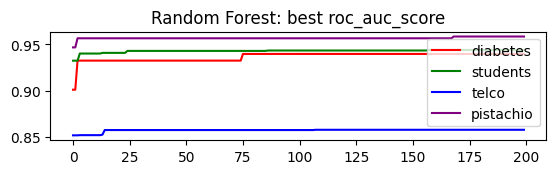

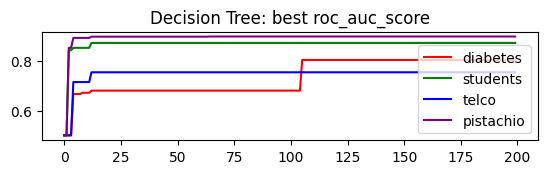

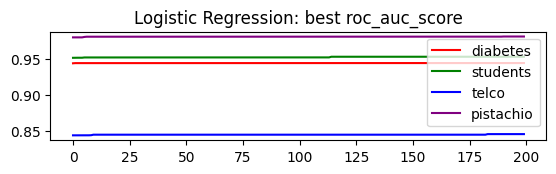

In [53]:
# best_metric_so_far('Random Forest')
chart_1()

# Bayes Search

In [72]:
best_bayes = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

best_bayes_score_history = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

In [73]:
# siatki parametrów bayes
param_space_bayes = {
    'Logistic Regression': {
        'model__C': Real(0.01, 100.0, prior='uniform'),  
        'model__penalty': ['l1', 'l2'],                  
        'model__solver': ['liblinear'],                  
    },
    'Decision Tree': { 
        'model__ccp_alpha': Real(0.0, 1.0, prior='uniform'), 
        'model__max_depth': Integer(1, 30),                  
        'model__min_samples_leaf': Integer(1, 60),           
        'model__min_samples_split': Integer(2, 60),           
    },
    'Random Forest': {  
        'model__n_estimators': Integer(1, 2000),              
        'model__max_samples': Real(0.01, 1.0, prior='uniform'), 
        'model__max_features': Real(0.01, 1.0, prior='uniform'),
        'model__min_samples_leaf': Integer(1, 30),            
    }
}



# clas_model = LogisticRegression(max_iter=5000)
# search_space =
#   [
#    {
#     "solver": Categorical(['liblinear']),
#     "penalty": Categorical(['l1', 'l2']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['lbfgs', 'newton-cg', 'sag']),
#     "penalty": Categorical(['l2', 'none']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['saga']),
#     "penalty": Categorical(['l1', 'l2', 'none']),
#     "fit_intercept": Categorical([True, False]),
#     #"warm_start": Categorical([True, False])
#    },
#    {
#     "solver": Categorical(['saga']),
#     "penalty": Categorical(['elasticnet']),
#     "fit_intercept": Categorical([True, False]),
#     "l1_ratio": Real(0, 1, prior='uniform'),
#     #"warm_start": Categorical([True, False])
#    },
#   ]
# bayes_search = BayesSearchCV(clas_model, search_space, n_iter=12, scoring="accuracy", n_jobs=-1, cv=5)


In [74]:
scoring_metric = roc_auc_score

def bayes_optimize(model,param_space):
    for dataset in datasets_wanted_size.keys():
        opt = BayesSearchCV(
        Pipeline([("trans",col_trans),("model",models[model]())]),
        param_space,
        n_iter=50, 
        cv=2,       
        n_jobs=-1,  
        scoring=make_scorer(scoring_metric, needs_proba=True)
        )

        opt.fit(datasets_X_train[dataset],datasets_y_train[dataset])
        
        best_bayes[model][dataset] = opt.best_estimator_
        best_bayes_score_history[model][dataset] = opt.cv_results_['mean_test_score']


# Loswe punkty startowe ,a zbieżnosć BayesSearch

In [75]:
import numpy as np
from scipy.stats import uniform, randint
from skopt.space import Real

def sample_starting_points(param_space, n):
    """
    Losuje n punktów startowych na podstawie zadanej przestrzeni hiperparametrów.
    
    Args:
        param_space (dict): Słownik opisujący przestrzeń hiperparametrów. 
                            Wartości mogą być typu Real, Integer, lub lista.
        n (int): Liczba punktów startowych do wylosowania.
    
    Returns:
        list[dict]: Lista słowników z wylosowanymi punktami startowymi.
    """
    sampled_points = []
    
    for _ in range(n):
        point = {}
        for param, space in param_space.items():
            if isinstance(space, list):  # Dyskretna lista wartości
                point[param] = np.random.choice(space)
            elif isinstance(space, tuple) and hasattr(space[0], 'rvs'):  # np. Real/Integer
                point[param] = space[0].rvs(*space[1:])  # Losowanie z określonego rozkładu
            elif hasattr(space, 'rvs'):  # np. uniform lub inne rozkłady
                point[param] = space.rvs()
            else:
                raise ValueError(f"Nieobsługiwany typ przestrzeni dla {param}: {type(space)}")
        sampled_points.append(point)
    
    return sampled_points

param_space = { 
        'ccp_alpha': uniform(0, 1), 
        'max_depth': randint(1, 31),
        'min_samples_leaf': randint(1, 61),  
        'min_samples_split': randint(2, 61), 
    }

n = 5
print(sample_starting_points(param_space, n))


[{'ccp_alpha': 0.5390996030897385, 'max_depth': 23, 'min_samples_leaf': 58, 'min_samples_split': 49}, {'ccp_alpha': 0.7285874061346955, 'max_depth': 26, 'min_samples_leaf': 38, 'min_samples_split': 48}, {'ccp_alpha': 0.8667693633479315, 'max_depth': 6, 'min_samples_leaf': 57, 'min_samples_split': 23}, {'ccp_alpha': 0.5326929706259862, 'max_depth': 21, 'min_samples_leaf': 16, 'min_samples_split': 4}, {'ccp_alpha': 0.48452025449448344, 'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 33}]


In [76]:
# funkcja do optymalizacji bayesowaskiej i plotowania dla roznych punktow startowych


import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score

bayes_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
} 
# Modified bayes_optimize function
def bayes_optimize2(model, param_space, n):


    # Nie wiem jak ustawic punkt startowy w tym gównie wiec zaczynam z roznymi random seedami
    random_seed = [int(i * abs(np.sin(i&10)) + 10) for i in range(1,n+1)]
    score_history = {}  
    starting_points = sample_starting_points(param_space, n)
    
    i = -1
    fig, axs = plt.subplots(1,4,figsize=(15, 5))
    for dataset in datasets_wanted_size.keys():
        
        i +=1
        for j in range(n):
            pipeline = Pipeline([("trans", copy.deepcopy(col_trans)), ("model", models[model]())])

            opt = BayesSearchCV(
                pipeline,
                param_space,
                n_iter=30,
                cv=2,
                n_jobs=-1,
                scoring=make_scorer(scoring_metric, needs_proba=True),
                random_state=random_seed[j]
                )

            opt.fit(
                datasets_X_train[dataset],
                datasets_y_train[dataset]
                    # Starting point for parameters
            )
            best_bayes[model][dataset] = opt.best_estimator_
            score_history[dataset] = opt.cv_results_['mean_test_score']
            bayes_history[model][dataset] = bayes_history[model][dataset] + list(score_history[dataset])
            # bayes_history[model][dataset]
            # print(list(score_history[dataset]))
            # print(bayes_history[model][dataset])
            axs[i].plot(score_history[dataset], label=f'{dataset}')
        axs[i].set_title(dataset)
        axs[i].set_ylim(.4,1)
    fig.suptitle('Bayes Optimization with different starting points for '+model, fontsize=16)
    plt.show()

    return best_bayes, score_history  # Return results for further inspection if needed


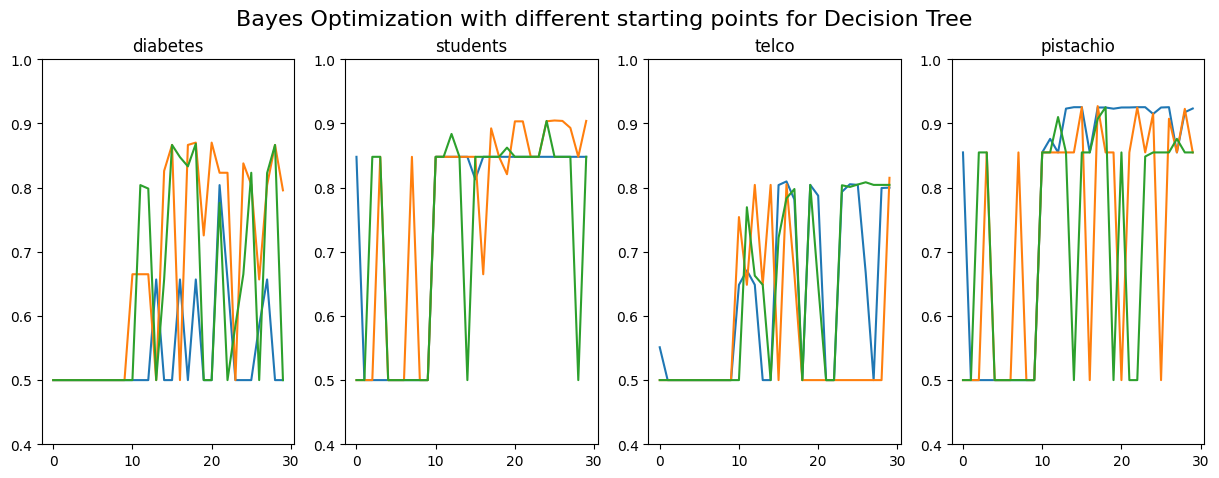

({'Random Forest': {'diabetes': Pipeline(steps=[('trans',
                    ColumnTransformer(transformers=[('numeric',
                                                     Pipeline(steps=[('impute',
                                                                      SimpleImputer()),
                                                                     ('scale',
                                                                      MinMaxScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x0000027928B36C00>),
                                                    ('cat',
                                                     Pipeline(steps=[('ohe',
                                                                      OneHotEncoder(drop='first')),
                                                                     ('impute',
                                                                      SimpleImpute

In [87]:
bayes_optimize2("Decision Tree", param_space_bayes['Decision Tree'],3)

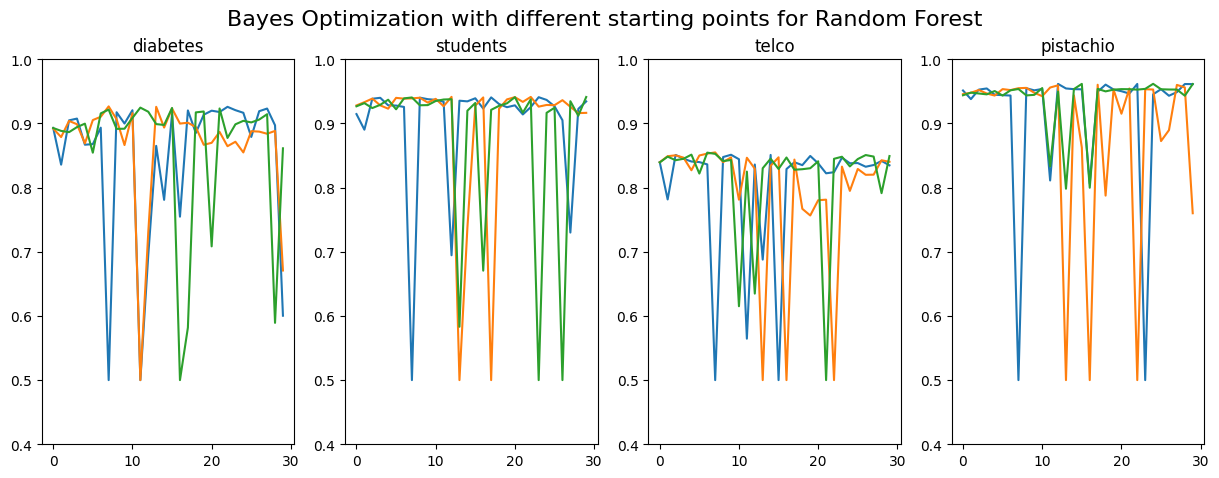

({'Random Forest': {'diabetes': Pipeline(steps=[('trans',
                    ColumnTransformer(transformers=[('numeric',
                                                     Pipeline(steps=[('impute',
                                                                      SimpleImputer()),
                                                                     ('scale',
                                                                      MinMaxScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x0000027928B36C00>),
                                                    ('cat',
                                                     Pipeline(steps=[('ohe',
                                                                      OneHotEncoder(drop='first')),
                                                                     ('impute',
                                                                      SimpleImpute

In [78]:
bayes_optimize2('Random Forest', param_space_bayes["Random Forest"],3)

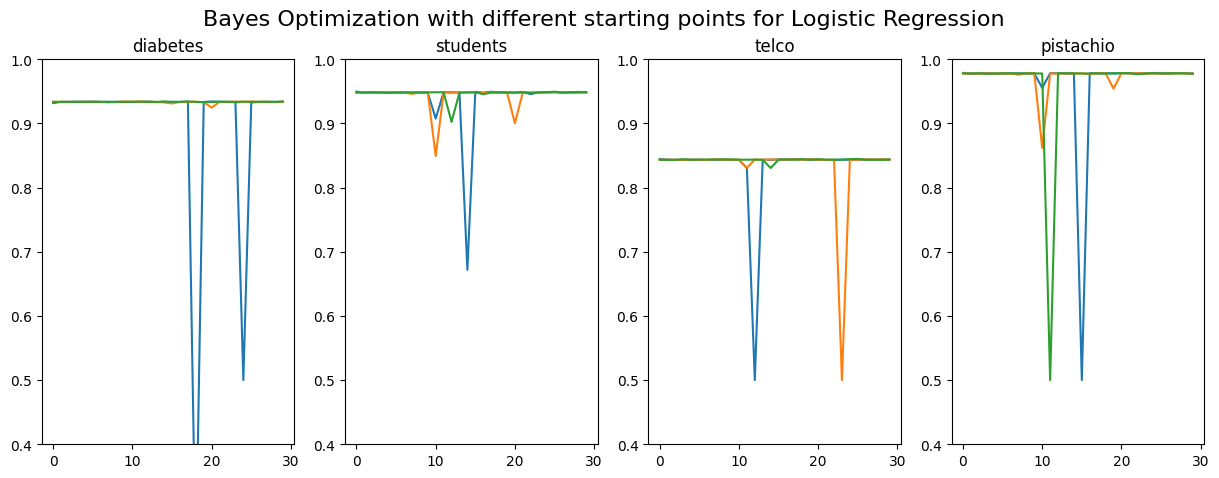

({'Random Forest': {'diabetes': None,
   'students': None,
   'telco': None,
   'pistachio': None},
  'Decision Tree': {'diabetes': None,
   'students': None,
   'telco': None,
   'pistachio': None},
  'Logistic Regression': {'diabetes': Pipeline(steps=[('trans',
                    ColumnTransformer(transformers=[('numeric',
                                                     Pipeline(steps=[('impute',
                                                                      SimpleImputer()),
                                                                     ('scale',
                                                                      MinMaxScaler())]),
                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x0000027928B0AA50>),
                                                    ('cat',
                                                     Pipeline(steps=[('ohe',
                                                        

In [77]:
bayes_optimize2('Logistic Regression', param_space_bayes["Logistic Regression"],3)

In [ ]:
for model in models.keys():
    for dataset in datasets_wanted_size.keys():
        print(model,dataset)
        print(np.mean(bayes_history[model][dataset]))
        print(np.std(bayes_history[model][dataset]))

Decision Tree diabetes
0.5
0.0
Decision Tree students
0.586997231127951
0.15068362443142388
Decision Tree telco
0.5063976062122962
0.01692647502385774
Decision Tree pistachio
0.5887082122093024
0.15364713059511345
Random Forest diabetes
0.8933533340476446
0.018713726129800132
Random Forest students
0.93077564849898
0.00938984257545421
Random Forest telco
0.8431470072305652
0.011602824588790382
Random Forest pistachio
0.9499855928642806
0.0038813816100281883
Logistic Regression diabetes
0.9334819993571198
0.0006660519781914138
Logistic Regression students
0.9483860390556689
0.0005140282258502008
Logistic Regression telco
0.8434964132403486
0.00039035075050410036
Logistic Regression pistachio
0.9780032135719476
0.00034166233350573503


# Inne techniki losowania punktów w random search

In [90]:
# mniejsze wartosci bardziej prawdopodobne

In [ ]:
# custom distribution for

import numpy as np
from scipy.stats import loguniform, uniform
from sklearn.model_selection import ParameterSampler

seed = 42
random.seed(seed)
np.random.seed(seed)
n_iter = 200


def weighted_randint(low, high, size=1):
    # Sample from an exponential distribution, then scale to [low, high)
    probs = np.exp(-np.linspace(0, 3, high - low))  # Exponentially decaying probabilities
    probs /= probs.sum()  # Normalize to sum to 1
    return np.random.choice(np.arange(low, high), size=size, p=probs)[0]

# Define parameter distributions with callable weighted_randint
param_distributions_exp = {
    'Logistic Regression': {
        'C': (loguniform, 0.01, 100),  
        'penalty': (list, ['l1', 'l2']),  
        'solver': (list, ['liblinear']),  
    },
    'Decision Tree': { 
        'ccp_alpha': (loguniform, 0.001, 1),
        'max_depth': (weighted_randint, 1, 31),
        'min_samples_leaf': (weighted_randint, 1, 31),  
        'min_samples_split': (weighted_randint, 2, 31),  
    },
    'Random Forest': {  
        'n_estimators': (weighted_randint, 1, 201), 
        'max_samples': (uniform, 0.1,.9),
        'max_features': (uniform, 0.01, .95), 
        'min_samples_leaf': (weighted_randint, 1, 31), 
    }
}

def sample_custom_dist(tup):
    if len(tup) ==2 :
        return tup[1][random.randint(0,len(tup[1])-1)]
    elif tup[0] == weighted_randint:
        return weighted_randint(tup[1],tup[2])
    else:
        return tup[0](tup[1],tup[2]).rvs()
        

param_samples_exp = {
    alg: 
        [({key:sample_custom_dist(tup) for key, tup in param_distributions_exp[alg].items()}) for i in range(n_iter)]
    
    for alg in param_distributions_exp.keys()
}
param_samples_exp

{'Logistic Regression': [{'C': 0.31489116479568624,
   'penalty': 'l1',
   'solver': 'liblinear'},
  {'C': 63.512210106407046, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 8.471801418819979, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 2.481040974867813, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 0.04207988669606638, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 0.042070539502879395, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 0.017073967431528128, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 29.154431891537552, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 2.5378155082656657, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 6.79657809075816, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 0.012087541473056965, 'penalty': 'l1', 'solver': 'liblinear'},
  {'C': 75.7947995334801, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 21.368329072358772, 'penalty': 'l2', 'solver': 'liblinear'},
  {'C': 0.07068974950624607, 'penalty': 'l1', 'solver': 'liblinear'},
  

In [128]:
m = -111
for i in param_samples_exp['Random Forest']:
    if i['max_features'] >m:
        m = i['max_features']
print(m)
m = -11
for i in range(100):
    m = max(m,uniform(0,1).rvs())
print(m)

0.9580374050066706
0.9918099513493635


In [141]:
optimization_metric = roc_auc_score
j=0
best_random_exp = {
    'Random Forest': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Decision Tree': {'diabetes': None,'students': None,'telco': None,'pistachio': None},
    'Logistic Regression' : {'diabetes': None,'students': None,'telco': None,'pistachio': None}
}

best_random_exp_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}

best_random_exp_history_params = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}
random_exp_history = {
    'Random Forest': {'diabetes': [],'students': [],'telco': [],'pistachio':  []},
    'Decision Tree': {'diabetes': [],'students': [],'telco': [],'pistachio': []},
    'Logistic Regression' : {'diabetes': [],'students': [],'telco': [],'pistachio': []}
}
def optimize_exp(model, param_samples):
    i = 0
    for dataset in datasets_wanted_size.keys():
        best_score = float('-inf')
        best_params = []
        for params in param_samples:
            
            estimator = models[model]()
            estimator.set_params(**params)
            pipe = Pipeline([("trans",col_trans),("model",estimator)])
            scores = cross_val_score(Pipeline([("trans",col_trans),("model",models[model]().set_params(**params))]), datasets_X_train[dataset], datasets_y_train[dataset], cv=3, scoring='roc_auc')  

            mean_score = scores.mean()
            std_score = scores.std()
            # estimator.fit(datasets_X_train[dataset], datasets_y_train[dataset]
            # y_pred = estimator.predict(datasets_X_test[dataset])
            # score = optimization_metric(datasets_y_test[dataset], y_pred)
            random_exp_history[model][dataset].append(mean_score)
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                best_random_exp[model][dataset] = Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params))])
                best_random_exp[model][dataset].fit(datasets_X_train[dataset], datasets_y_train[dataset])
            best_random_exp_history[model][dataset].append(best_score)
            best_random_exp_history_params[model][dataset].append(best_params)
            i+=1
            # print(i,j)
    
            

In [143]:
optimize_exp('Decision Tree', param_samples_exp['Decision Tree'])
    

In [144]:
optimize_exp('Random Forest', param_samples_exp['Random Forest'])

In [145]:
optimize_exp('Logistic Regression', param_samples_exp['Logistic Regression'])

In [ ]:
for model in models.keys():
    for dataset in datasets_wanted_size.keys():
        print(model,dataset)
        print(np.mean(random_exp_history[model][dataset]))
        print(np.std(random_exp_history[model][dataset]))

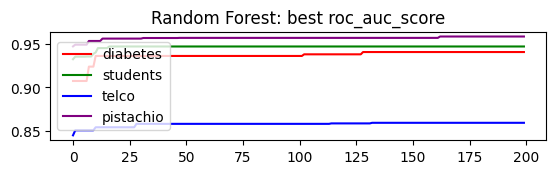

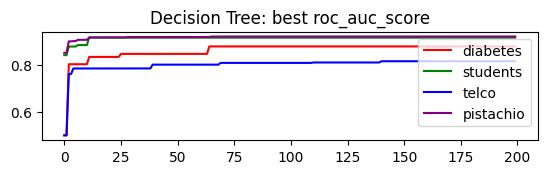

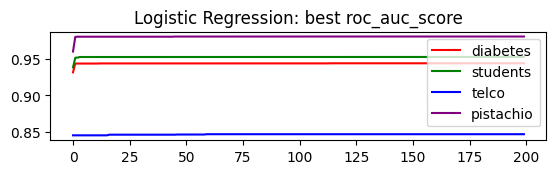

In [146]:
# ile iteracji każdej metody potrzebujemy żeby uzyskać stabilne wyniki optymalizacji
def best_metric_so_far_exp(model):
    kolory = {
        'diabetes': 'red',
        'students': 'green',
        'telco': 'blue',
        'pistachio': 'purple'
    }
    for key  in best_random_exp_history[model].keys():
        plt.plot(best_random_exp_history[model][key],label = key,c = kolory[key])
    plt.legend()
    plt.title(f'{model}: best roc_auc_score')
    # plt.xticks([i for i in range(n_iter)], labels=[i+1 for i in range(n_iter)])
    plt.show()
    return

def chart_exp_dist():
    for i,key  in enumerate(best_random_exp_history.keys()):
        # print(i,key)
        plt.subplot(3, 1, i+1)
        best_metric_so_far_exp(key)
    return
chart_exp_dist()

# Critical difference diagrams

In [ ]:
# jakies gówno mozna babeczki o to spytac bo dziwne wyniki daje i python sie wywala xd

In [ ]:
example_df = pd.DataFrame(data = None, columns=['classifier_name','dataset_name','accuracy'])
for model,scores in best_scores_bayes.items():
    # print(model, scores)

    for dataset, score in scores.items():
        example_df = example_df._append({'classifier_name':model+' B','dataset_name':dataset,'accuracy':score},ignore_index=True)

for model,scores in best_scores_random.items():
    # print(model, scores)

    for dataset, score in scores.items():
        example_df = example_df._append({'classifier_name':model+' R','dataset_name':dataset,'accuracy':score},ignore_index=True)


for model,scores in best_scores_random_exp.items():
    # print(model, scores)
    for dataset, score in scores.items():
        example_df = example_df._append({'classifier_name':model+' RE','dataset_name':dataset,'accuracy':score},ignore_index=True)

example_df.to_csv('example.csv', index=False)  

NameError: name 'best_scores_random_exp' is not defined

In [ ]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets


df_perf = pd.read_csv('example.csv', index_col=False)

draw_cd_diagram(df_perf=df_perf, title='Roc Auc', labels=True)

# Model tunability 

In [79]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

criterion = roc_auc_score

best_scores_random = {}
deafult_scores = {}
tunability_random = {}

In [80]:
# loss dla deafult modeli

for model in models.keys():
    deafult_model = Pipeline([("trans",col_trans),("model",models[model]())])
    deafult_scores[model] = {}
    for dataset in datasets_wanted_size.keys():
        deafult_model.fit(datasets_X_train[dataset] , datasets_y_train[dataset])
        deafult_scores[model][dataset] =  criterion(datasets_y_test[dataset] , deafult_model.predict(datasets_X_test[dataset]))



In [81]:
# tunability random

for model in models.keys():
    best_scores_random[model] = {}
    for dataset in datasets_wanted_size.keys():
        best_scores_random[model][dataset] =  criterion(
            datasets_y_test[dataset],
            best_random[model][dataset].predict(datasets_X_test[dataset])
            )

tunability_random = {}
for model in models.keys():
    tunability_random[model] = {}
    for dataset in datasets_wanted_size.keys():
        tunability_random[model][dataset] = deafult_scores[model][dataset] - best_scores_random[model][dataset]

In [147]:
# tunability random exp
criterion = roc_auc_score

best_scores_random_exp = {}
tunability_random_exp = {}

for model in models.keys():
    best_scores_random_exp[model] = {}
    for dataset in datasets_wanted_size.keys():
        best_scores_random_exp[model][dataset] =  criterion(
            datasets_y_test[dataset],
            best_random_exp[model][dataset].predict(datasets_X_test[dataset])
            )


for model in models.keys():
    tunability_random_exp[model] = {}
    for dataset in datasets_wanted_size.keys():
        tunability_random_exp[model][dataset] = deafult_scores[model][dataset] - best_scores_random_exp[model][dataset]

In [88]:
# tunability bayes
criterion = roc_auc_score

best_scores_bayes = {}
tunability_bayes = {}

for model in models.keys():
    best_scores_bayes[model] = {}
    for dataset in datasets_wanted_size.keys():
        best_scores_bayes[model][dataset] =  criterion(
            datasets_y_test[dataset],
            best_bayes[model][dataset].predict(datasets_X_test[dataset])
            )


for model in models.keys():
    tunability_bayes[model] = {}
    for dataset in datasets_wanted_size.keys():
        tunability_bayes[model][dataset] = deafult_scores[model][dataset] - best_scores_bayes[model][dataset]

In [84]:
from sklearn.metrics import log_loss

criterion = roc_auc_score

def randomSearchForSingleParam(model,param,n_iter=n_iter):
    best_random_history = {key: [] for key in datasets_wanted_size.keys()}
    best_random_param = {key: None for key in datasets_wanted_size.keys()}

    param_distributions_for_param  = {param: param_distributions[model][param]}
    param_samples_for_param = list(ParameterSampler(param_distributions_for_param, n_iter=n_iter, random_state=seed))
       
    for dataset in datasets_wanted_size.keys():
        best_score = float('-inf')
        for params in param_samples_for_param:
            
            estimator = models[model]()
            estimator.set_params(**params)
            pipe = Pipeline([("trans",col_trans),("model",estimator)])
            scores = cross_val_score(Pipeline([("trans",col_trans),("model",models[model]().set_params(**params))]), datasets_X_train[dataset], datasets_y_train[dataset], cv=3, scoring='roc_auc')  

            mean_score = scores.mean()
            std_score = scores.std()
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
            best_random_history[dataset].append(best_score)
        best_random_param[dataset] = best_params
    return best_random_param,best_random_history

def tunabilityForSingleParamSingleDataset(model,params):
    # param w postaci np.{'diabetes': {'n_estimators': 1127},
#                         'students': {'n_estimators': 1127},
#                         'telco': {'n_estimators': 1131},
#                         'pistachio': {'n_estimators': 861}},

    res = {dataset: None for dataset in params.keys()}

    for dataset in params.keys():
        best_param_model = Pipeline([("trans",copy.deepcopy(col_trans)),("model",models[model]().set_params(**params[dataset]))])
        best_param_model.fit(datasets_X_train[dataset], datasets_y_train[dataset])
        best_scores =  criterion(datasets_y_test[dataset],best_param_model.predict(datasets_X_test[dataset]))

        deafult_model = Pipeline([("trans",col_trans),("model",models[model]())])
        deafult_model.fit(datasets_X_train[dataset] , datasets_y_train[dataset])
        deafult_scores =  criterion(datasets_y_test[dataset] , deafult_model.predict(datasets_X_test[dataset]))
        res[dataset] = (deafult_scores - best_scores)
    return res



In [ ]:
# randomSearchForSingleParam('Random Forest', 'n_estimators')
# ({'diabetes': {'n_estimators': 1127},
#   'students': {'n_estimators': 1127},
#   'telco': {'n_estimators': 1131},
#   'pistachio': {'n_estimators': 861}},
#  {'diabetes': [0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946,
#    0.9299126754526946],
#   'students': [0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688,
#    0.9471904063242688],
#   'telco': [0.8314294271167588,
#    0.8314294271167588,
#    0.8334884268172679,
#    0.8334884268172679,
#    0.8337290891199247],
#   'pistachio': [0.9559172555668348,
#    0.9559172555668348,
#    0.9560065384295608,
#    0.9560065384295608,
#    0.9560065384295608]})

[{'n_estimators': 1127}, {'n_estimators': 1460}, {'n_estimators': 861}, {'n_estimators': 1295}, {'n_estimators': 1131}]


({'diabetes': {'n_estimators': 1127},
  'students': {'n_estimators': 1127},
  'telco': {'n_estimators': 1131},
  'pistachio': {'n_estimators': 861}},
 {'diabetes': [0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946,
   0.9299126754526946],
  'students': [0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688,
   0.9471904063242688],
  'telco': [0.8314294271167588,
   0.8314294271167588,
   0.8334884268172679,
   0.8334884268172679,
   0.8337290891199247],
  'pistachio': [0.9559172555668348,
   0.9559172555668348,
   0.9560065384295608,
   0.9560065384295608,
   0.9560065384295608]})

In [ ]:
# tunabilityForSingleParamSingleDataset('Random Forest', {'diabetes': {'n_estimators': 1127},
#   'students': {'n_estimators': 1127},
#   'telco': {'n_estimators': 1131},
#   'pistachio': {'n_estimators': 861}})

{'diabetes': -0.0018181818181818299,
 'students': 0.0015412638363457853,
 'telco': -0.017045454545454475,
 'pistachio': 0.008720930232558044}

In [85]:
# tunability poszczególnych hiperparam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def chart_2(parametry,wartosci):
    # Przykładowe dane:
    # parametry = ['param1', 'param2', 'param3', 'param4'], parametry to mogą być nazwy modeli wyjdzie na to samo
    # wartosci = [
    #     {'diabetes': -0.0018, 'students': 0.0015, 'telco': -0.017, 'pistachio': 0.0087},
    #     {'diabetes': -0.005, 'students': 0.0021, 'telco': -0.013, 'pistachio': 0.0103},
    #     {'diabetes': -0.003, 'students': 0.0019, 'telco': -0.015, 'pistachio': 0.0098},
    #     {'diabetes': -0.0042, 'students': 0.0017, 'telco': -0.016, 'pistachio': 0.0112}
    # ]

    # Przekształć dane na DataFrame
    dane = []
    for param, slownik in zip(parametry, wartosci):
        for klucz, wartosc in slownik.items():
            dane.append({'Parametr': param, 'Klucz': klucz, 'Wartość': wartosc})
    df = pd.DataFrame(dane)

    # Definiowanie kolorów dla kluczy
    kolory = {
        'diabetes': 'red',
        'students': 'green',
        'telco': 'blue',
        'pistachio': 'purple'
    }

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Parametr', y='Wartość', data=df,color='white',showcaps = False) 
    sns.stripplot(
        x='Parametr', 
        y='Wartość', 
        hue='Klucz', 
        data=df, 
        palette=kolory, 
        dodge=True,  # Oddziel punkty dla różnych kluczy
        # jitter=True  # Rozproszenie punktów wzdłuż osi X dla lepszej widoczności,
    )
    plt.xlabel('')
    plt.axhline(y=0, color='r', linestyle='-')
    # Dostosowanie legendy
    plt.legend(title='Klucz', loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Tunability dla różnych parametrów/modeli')
    plt.show()

parametry = ['param1', 'param2', 'param3', 'param4']
wartosci = [
    {'diabetes': -0.0018, 'students': 0.0015, 'telco': -0.017, 'pistachio': 0.0087},
    {'diabetes': -0.005, 'students': 0.0021, 'telco': -0.013, 'pistachio': 0.0103},
    {'diabetes': -0.003, 'students': 0.0019, 'telco': -0.015, 'pistachio': 0.0098},
    {'diabetes': -0.0042, 'students': 0.0017, 'telco': -0.016, 'pistachio': 0.0112}
]
# chart_2(parametry,wartosci)

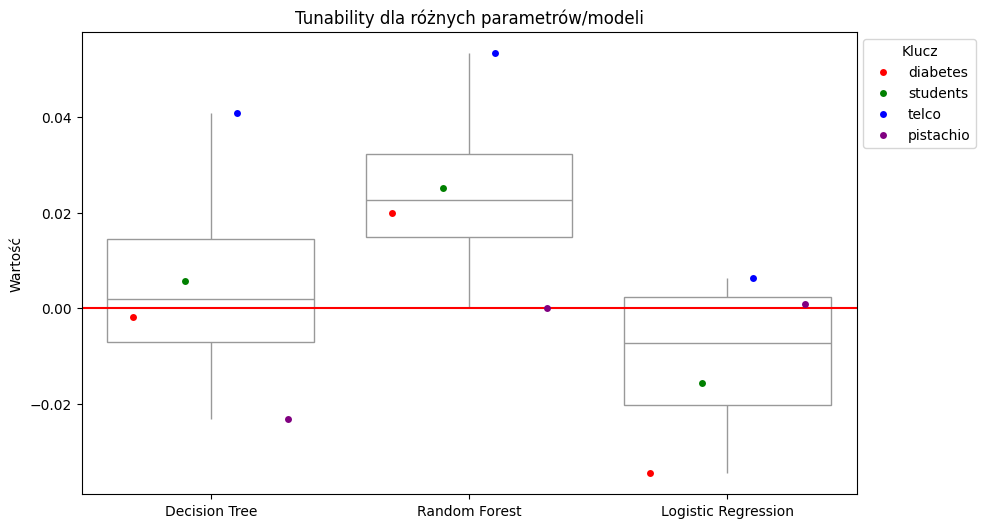

{'Decision Tree': {'diabetes': -0.0018181818181818299,
  'students': 0.005674653215636871,
  'telco': 0.040909090909091006,
  'pistachio': -0.02316497093023251},
 'Random Forest': {'diabetes': 0.020000000000000018,
  'students': 0.025290738405492563,
  'telco': 0.05340909090909096,
  'pistachio': 0.0},
 'Logistic Regression': {'diabetes': -0.03454545454545466,
  'students': -0.015552753257671359,
  'telco': 0.006249999999999978,
  'pistachio': 0.0009992732558139483}}

In [86]:
# tunability random chart
l1 = []
l2 = []
for key,val in tunability_random.items():
    l1.append(key)
    l2.append(val)
chart_2(l1,l2)
tunability_random

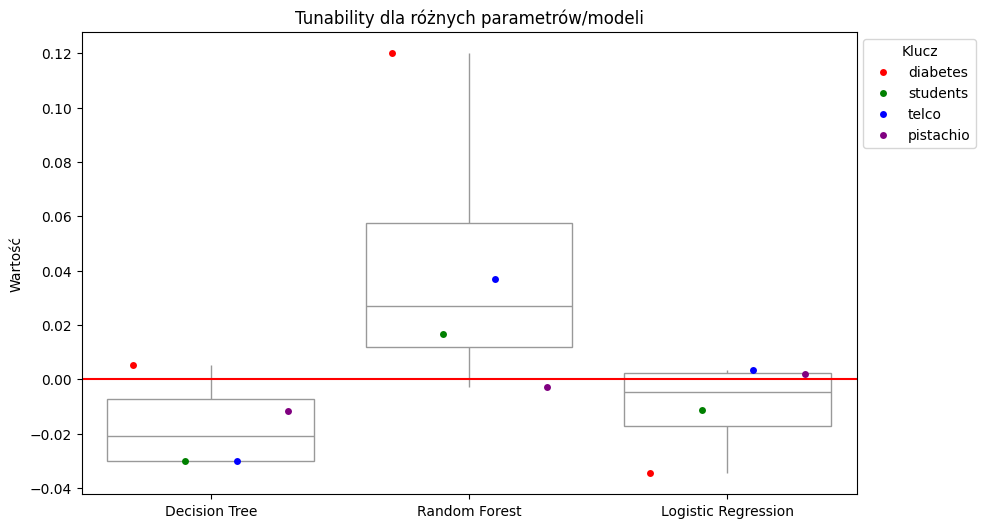

{'Decision Tree': {'diabetes': 0.8781818181818182, 'students': 0.8727056186072579, 'telco': 0.709659090909091, 'pistachio': 0.8033248546511628}, 'Random Forest': {'diabetes': 0.88, 'students': 0.913689225164635, 'telco': 0.7477272727272728, 'pistachio': 0.8490188953488373}, 'Logistic Regression': {'diabetes': 0.76, 'students': 0.8926719910326467, 'telco': 0.7329545454545454, 'pistachio': 0.8754542151162791}}
{'Decision Tree': {'diabetes': 0.8727272727272727, 'students': 0.902760263416001, 'telco': 0.7397727272727272, 'pistachio': 0.8148619186046512}, 'Random Forest': {'diabetes': 0.76, 'students': 0.8969454953061511, 'telco': 0.7107954545454546, 'pistachio': 0.8519258720930233}, 'Logistic Regression': {'diabetes': 0.7945454545454547, 'students': 0.9039512400168138, 'telco': 0.7295454545454546, 'pistachio': 0.8734556686046512}}


In [148]:
# tunability random exp chart

l1 = []
l2 = []
for key,val in tunability_random_exp.items():
    l1.append(key)
    l2.append(val)
chart_2(l1,l2)

print(deafult_scores)
print(best_scores_random_exp)

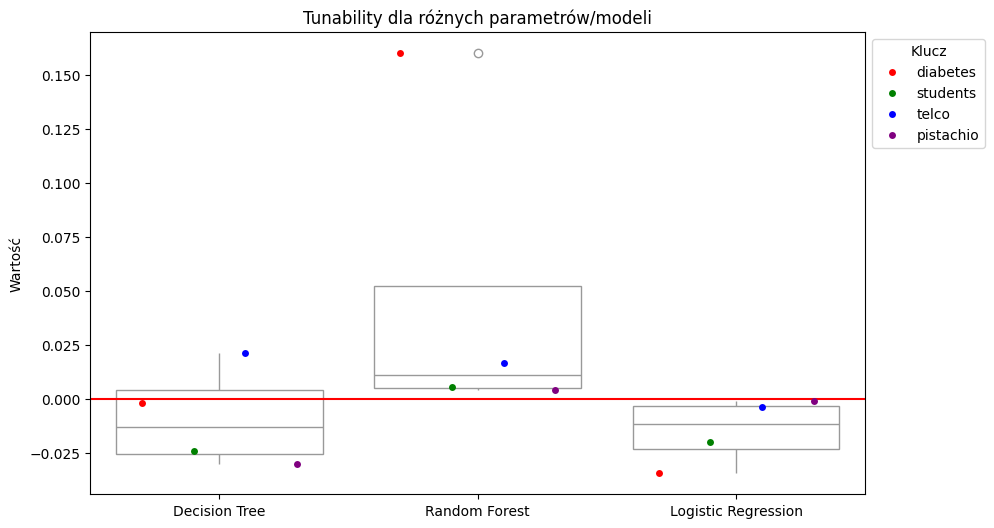

In [89]:
# tunability bayes chart
l1 = []
l2 = []
for key,val in tunability_bayes.items():
    l1.append(key)
    l2.append(val)
chart_2(l1,l2)